In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# Configuración visual
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

### Cargar y explorar el dataset

In [3]:
df=pd.read_csv('../data/Bengaluru_House_Data.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
print(f'Filas: {df.shape[0]}, Columnas: {df.shape[1]}')


Filas: 13320, Columnas: 9


In [5]:
# Información general
df.info()

# Estadísticas iniciales
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


### Limpieza de columnas clave

In [6]:
# columnas del dataset
df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [7]:
# valores nulos por columna
df.isnull().sum().sort_values(ascending=False)

society         5502
balcony          609
bath              73
size              16
location           1
area_type          0
availability       0
total_sqft         0
price              0
dtype: int64

### Eliminar columnas que no se usaran

In [8]:
df.drop(columns=['area_type','society','availability'],inplace=True)
df.shape

(13320, 6)

### Limpiar columna size → sacar número de habitaciones

In [9]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', nan, '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [10]:
df['bhk']=df['size'].str.extract(r'(\d+)').astype(float)
df['bhk'].value_counts()
# Eliminar la columna 'size' original porque ya no se necesita y contiene texto
df = df.drop('size', axis=1)

### Limpiar columna total_sqft

In [11]:
#función para convertir todos a número

def convert_sqft_to_num(x):
    try:
        if '-' in str(x):
            vals=x.split('-')
            return (float(vals[0])+float(vals[1]))/2
        elif any(char.isalpha() for char in str(x)):
            return None
        return float(x)
    except:
        return None
    
df['total_sqft']=df['total_sqft'].apply(convert_sqft_to_num)
df['total_sqft'].isnull().sum()

np.int64(46)

### Crear nueva columna: price_per_sqft

In [12]:
# convertir el precio a "precio por pie cuadrado"

df['price_per_sqft']=(df['price']*100000)/df['total_sqft']
df[['price','total_sqft','price_per_sqft']].head()

,price,total_sqft,price_per_sqft
0,39.07,1056.0,3699.810606
1,120.00,2600.0,4615.384615
2,62.00,1440.0,4305.555556
3,95.00,1521.0,6245.890861
4,51.00,1200.0,4250.000000


### Normalizar y agrupar la columna location

In [13]:
df['location']=df['location'].fillna('Unknown')
df['location']=df['location'].apply(lambda x: x.strip())
location_stats=df['location'].value_counts()

# agrupar las ubicaciones con muy pocos registros como "Other"
locations_to_replace=location_stats[location_stats<=10].index
df['location']=df['location'].apply(lambda x: 'Other' if x in locations_to_replace else x)
df['location'].nunique()

242

### Manejar valores nulos en columnas bath y balcony

In [14]:
# llenar los nulos con la mediana (más seguro que el promedio)
df['bath']=df['bath'].fillna(df['bath'].median())
df['balcony']=df['balcony'].fillna(df['balcony'].median())

In [15]:
# ver rápidamente para que todo esté bien:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   location        13320 non-null  object 
 1   total_sqft      13274 non-null  float64
 2   bath            13320 non-null  float64
 3   balcony         13320 non-null  float64
 4   price           13320 non-null  float64
 5   bhk             13304 non-null  float64
 6   price_per_sqft  13274 non-null  float64
dtypes: float64(6), object(1)
memory usage: 728.6+ KB


,total_sqft,bath,balcony,price,bhk,price_per_sqft
count,13274.000000,13320.000000,13320.000000,13320.000000,13304.000000,1.327400e+04
mean,1559.626694,2.688814,1.603378,112.565627,2.803743,7.907501e+03
std,1238.405258,1.338754,0.803067,148.971674,1.294974,1.064296e+05
min,1.000000,1.000000,0.000000,8.000000,1.000000,2.678298e+02
25%,1100.000000,2.000000,1.000000,50.000000,2.000000,4.266865e+03
50%,1276.000000,2.000000,2.000000,72.000000,3.000000,5.434306e+03
75%,1680.000000,3.000000,2.000000,120.000000,3.000000,7.311746e+03
max,52272.000000,40.000000,3.000000,3600.000000,43.000000,1.200000e+07


In [16]:
# guardamos una primera versión limpia
df.to_csv('../data/housing_cleaned.csv',index=False)

### Filtrar registros con tamaño por BHK irreal

Normalmente una habitación debe tener al menos 300 sqft, así que descartamos registros donde el total es menor a bhk * 300

In [17]:
df=df[df['total_sqft']/df['bhk']>=300]
df.shape

(12514, 7)

### Eliminar outliers en price_per_sqft

In [18]:
df['price_per_sqft'].describe()

count     12514.000000
mean       6307.367132
std        4160.773691
min         267.829813
25%        4210.762120
50%        5295.073227
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [21]:
# Función para eliminar outliers por ubicación en price_per_sqft
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        if subdf.shape[0] < 5: 
            continue
        m = subdf['price_per_sqft'].mean()
        st = subdf['price_per_sqft'].std()
        # Validación por si la desviación estándar es nula o NaN
        if pd.isna(st) or st == 0:
            continue
        reduced_df = subdf[(subdf['price_per_sqft'] >= (m - st)) & (subdf['price_per_sqft'] <= (m + st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

# Cargar el dataset limpio si no se ha cargado antes
df_clean = pd.read_csv("../data/housing_cleaned_final.csv")

# Paso 1: Eliminar outliers por ubicación en price_per_sqft
df_filtrado = remove_pps_outliers(df_clean)

# Función para detectar outliers con IQR
def detectar_outliers_iqr(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    return (df[columna] < (Q1 - 1.5 * IQR)) | (df[columna] > (Q3 + 1.5 * IQR))

# Paso 2: Detectar outliers globales
out_precio = detectar_outliers_iqr(df_filtrado, 'price')
out_area = detectar_outliers_iqr(df_filtrado, 'total_sqft')
out_bhk = detectar_outliers_iqr(df_filtrado, 'bhk')

# Consolidar todos los outliers
df_filtrado['outlier_global'] = out_precio | out_area | out_bhk

# Crear el dataset final sin ningún outlier
df_final = df_filtrado[~df_filtrado['outlier_global']].copy()

# Mostrar resumen
print("Registros originales:", df_clean.shape[0])
print("Tras eliminar outliers por ubicación:", df_filtrado.shape[0])
print("Outliers globales detectados:", df_filtrado['outlier_global'].sum())
print("Dataset final limpio:", df_final.shape[0])


Registros originales: 10242
Tras eliminar outliers por ubicación: 7022
Outliers globales detectados: 696
Dataset final limpio: 6326


### Eliminar casas con más baños que habitaciones

In [22]:
df=df[df['bath']<=df['bhk']+1]

### Verificar datos finales

In [23]:
df.info()
df.describe()
df['location'].nunique()

<class 'pandas.core.frame.DataFrame'>
Index: 12361 entries, 0 to 13319
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   location        12361 non-null  object 
 1   total_sqft      12361 non-null  float64
 2   bath            12361 non-null  float64
 3   balcony         12361 non-null  float64
 4   price           12361 non-null  float64
 5   bhk             12361 non-null  float64
 6   price_per_sqft  12361 non-null  float64
dtypes: float64(6), object(1)
memory usage: 772.6+ KB


242

In [25]:
# versión final limpia
df['bath'] = df['bath'].astype(int)
df['balcony'] = df['balcony'].astype(int)
df['bhk'] = df['bhk'].astype(int)
df['price'] = df['price'].astype(float)
df['price_per_sqft']=df['price_per_sqft'].round(2)


df.to_csv('../data/housing_cleaned_final.csv', index=False)
print("Archivo exportado como 'housing_final_limpio.csv'")

Archivo exportado como 'housing_final_limpio.csv'


## Cargar datos limpios a PostgreSQL

In [26]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine
load_dotenv()
usuario = os.getenv('PG_USER')
contraseña = os.getenv('PG_PASSWORD')
host = os.getenv('PG_HOST')
puerto = os.getenv('PG_PORT')
bd = os.getenv('PG_DATABASE')

engine = create_engine(f'postgresql+psycopg2://{usuario}:{contraseña}@{host}:{puerto}/{bd}')
df.to_sql('housing_data', engine, if_exists='replace', index=False)

361

# Análisis exploratorio visual con matplotlib y seaborn|

###  Distribución del precio por pie cuadrado (price_per_sqft)

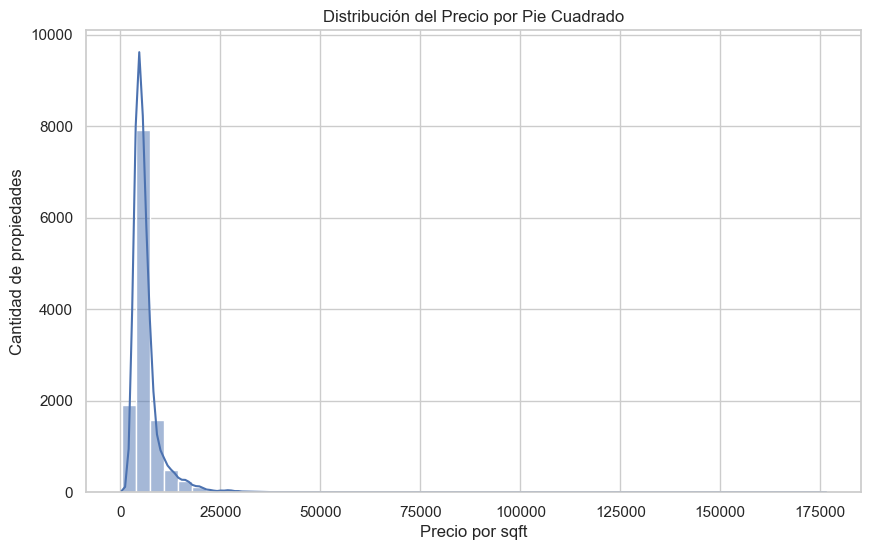

In [27]:
plt.figure(figsize=(10,6))
sns.histplot(df['price_per_sqft'],bins=50,kde=True)
plt.title('Distribución del Precio por Pie Cuadrado')
plt.xlabel('Precio por sqft')
plt.ylabel('Cantidad de propiedades')
plt.show()

### Precio promedio por ubicación (Top 20 zonas)

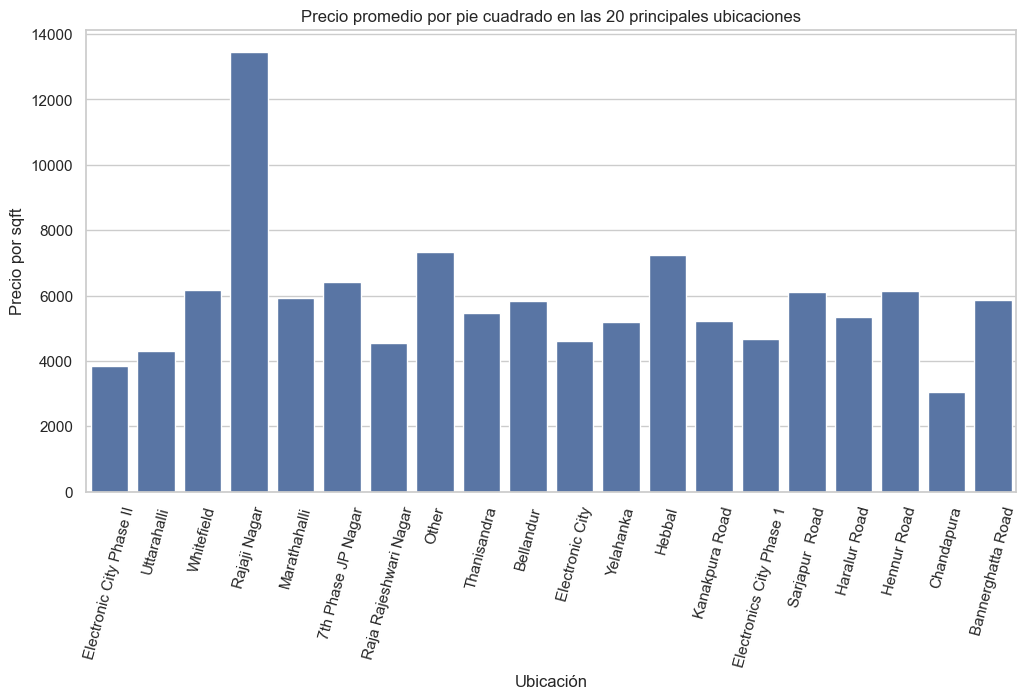

In [28]:
top_locations=df['location'].value_counts().head(20).index
top_df=df[df['location'].isin(top_locations)]

plt.figure(figsize=(12,6))
sns.barplot(data=top_df,x='location',y='price_per_sqft',estimator='mean',errorbar=None)
plt.xticks(rotation=75)
plt.title('Precio promedio por pie cuadrado en las 20 principales ubicaciones')
plt.ylabel('Precio por sqft')
plt.xlabel('Ubicación')
plt.show()

### Relación entre habitaciones (bhk) y precio

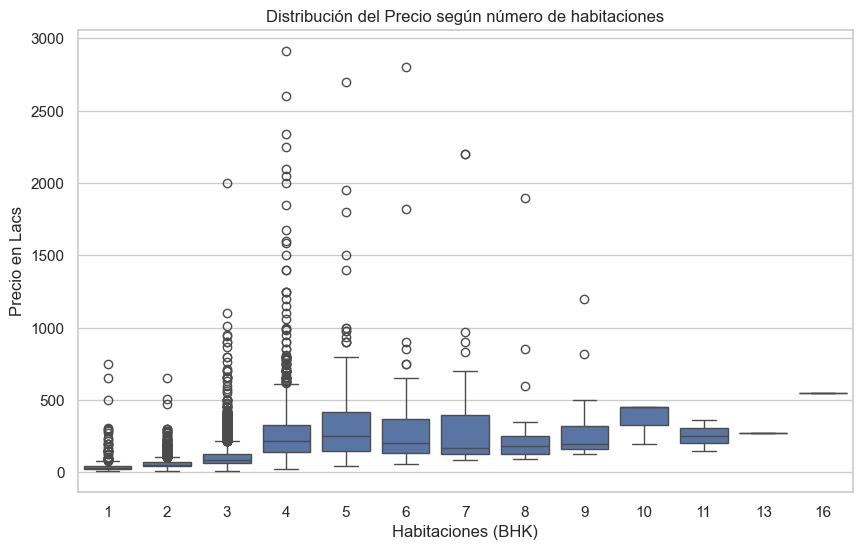

In [29]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df,x='bhk',y='price')
plt.title('Distribución del Precio según número de habitaciones')
plt.xlabel('Habitaciones (BHK)')
plt.ylabel('Precio en Lacs')
plt.show()

### Tamaño de propiedad vs precio

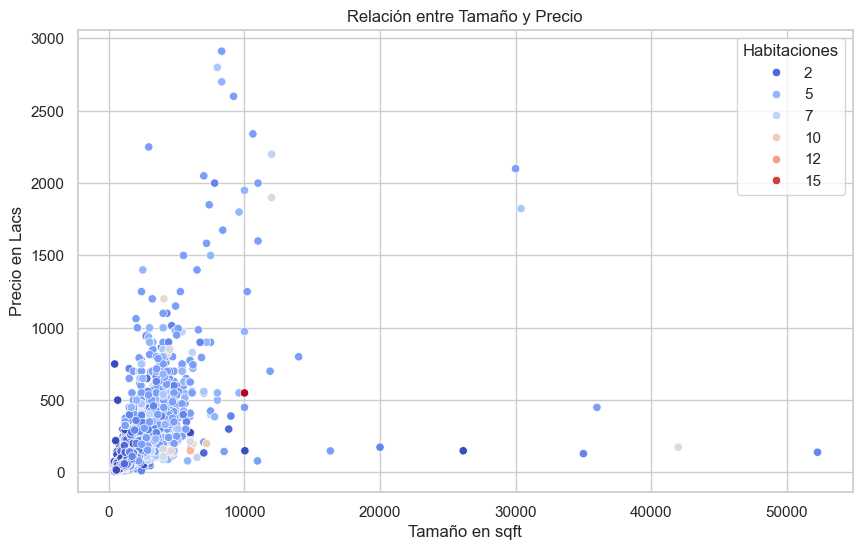

In [30]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df,x='total_sqft',y='price',hue='bhk',palette='coolwarm')
plt.title('Relación entre Tamaño y Precio')
plt.xlabel('Tamaño en sqft')
plt.ylabel('Precio en Lacs')
plt.legend(title='Habitaciones')
plt.show()

### Correlación entre variables numéricas

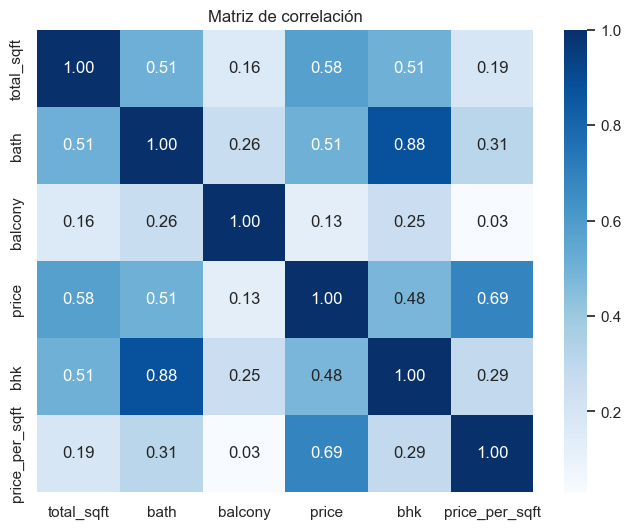

In [31]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='Blues',fmt='.2f')
plt.title('Matriz de correlación')
plt.show()

# Modelo de regresión lineal para predecir precio

### One-Hot Encoding de la columna location

In [32]:
dummies=pd.get_dummies(df['location'],drop_first=True)
df_model=pd.concat([df.drop('location',axis=1),dummies],axis=1)
df_model.head()

,total_sqft,bath,balcony,price,bhk,price_per_sqft,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1056.0,2,1,39.07,2,3699.81,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2600.0,5,3,120.00,4,4615.38,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1440.0,2,3,62.00,3,4305.56,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1521.0,3,1,95.00,3,6245.89,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1200.0,2,1,51.00,2,4250.00,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Definir X (features) y y (target)

In [33]:
X=df_model.drop('price',axis=1)
y=df_model['price']

### Separar datos de entrenamiento y prueba

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

###  Entrenar el modelo

In [35]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Evaluar el modelo

In [36]:
y_pred = rf.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

RMSE: 12.014575657678598
R2 Score: 0.9913218988222153


In [37]:
def predict_price(location, sqft, bath, balcony, bhk):
    if location not in X.columns:
        print(f"Ubicación '{location}' no está en el entrenamiento.")
        return None

    x = np.zeros(X.shape[1])
    x[0] = sqft
    x[1] = bath
    x[2] = balcony
    x[3] = bhk

    loc_index = np.where(X.columns == location)[0][0]
    x[loc_index] = 1

    price = rf.predict(pd.DataFrame([x], columns=X.columns))[0]
    return round(price, 2) if price > 0 else 0.0

print('Whitefield' in X.columns)
predict_price('Harlur', 1500, 2, 2, 3)

True


np.float64(31.4)

### Guardar el modelo

In [38]:
import joblib
joblib.dump(rf,'../model/house_price_model.pkl')

['../model/house_price_model.pkl']

In [39]:
import json
model_colums=list(X.columns)

with open('../model/model_columns.json','w') as f:
    json.dump(model_colums,f)